In [17]:
import os
import numpy as np
import torch
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
from tqdm import tqdm
import time

In [18]:
# Corollary 2.4 in Mohammadi 2014 - for 1d
def alpha_estimator_one(m, X):
    N = len(X)
    n = int(N/m) # must be an integer
    
    X = X[0:n*m]
    
    Y = np.sum(X.reshape(n, m),1)
    eps = np.spacing(1)

    Y_log_norm =  np.log(np.abs(Y) + eps).mean()
    X_log_norm =  np.log(np.abs(X) + eps).mean()
    diff = (Y_log_norm - X_log_norm) / math.log(m)
    return 1 / diff

In [19]:
# Corollary 2.4 in Mohammadi 2014 - for multi-d
def alpha_estimator_multi(m, X):
    # X is N by d matrix
    N = X.size()[0]   
    n = int(N/m) # must be an integer
#     print(N,n)
    X = X[0:n*m,:]
#     print(X.size())
    Y = torch.sum(X.view(n, m, -1), 1)
    eps = np.spacing(1)
    Y_log_norm = torch.log(Y.norm(dim=1) + eps).mean()
    X_log_norm = torch.log(X.norm(dim=1) + eps).mean()
    diff = (Y_log_norm - X_log_norm) / math.log(m)
    return 1 / diff.item()

In [20]:
class simpleNet(nn.Module):

    def __init__(self, input_dim=28*28 , width=128, depth=3, num_classes=10):
        super(simpleNet, self).__init__()
        self.input_dim = input_dim 
        self.width = width
        self.depth = depth
        self.num_classes = num_classes
        
        layers = self.get_layers()

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, self.width, bias=False),
            nn.ReLU(inplace=True),
            *layers,
            nn.Linear(self.width, self.num_classes, bias=False),
        )

    def get_layers(self):
        layers = []
        for i in range(self.depth - 2):
            layers.append(nn.Linear(self.width, self.width, bias=False))
            layers.append(nn.ReLU())
        return layers

    def forward(self, x):
        x = x.view(x.size(0), self.input_dim)
        x = self.fc(x)
        return x

In [21]:
# PATH = './3FCN-MNIST/'
# lr_list = np.linspace(0.001,0.1,20)
PATH = './3FCN-MNIST-decentralized/'
lr_list = np.linspace(0.01,0.4,10)

depth = 3
num_nets = 900
nets = []
        

In [22]:
def get_layerWise(net):
    w = []
    flag=0
    for p in net.parameters():    
        if p.requires_grad:
            if flag==1:
#                 w[-1]=torch.cat((w[-1],p.view(-1,1)),1)
                flag=0
            else:
                flag=1
                w.append(p)
    for i in range(len(w)):
        w[i]=w[i].detach().numpy()
    res=np.array(w)
    return res

In [23]:
def compute_alphas_centralized(etas, PATH, depth):
    alphas_mc    = np.zeros((len(etas), depth))-1
    alphas_multi = np.zeros((len(etas), depth))-1
    alphas_single= np.zeros(len(etas))-1
    alphas_haus    = np.zeros((len(etas), depth))-1
    
    
    
    for ei, eta in tqdm(enumerate(etas)):
        
        tmp_path = PATH + 'LR{}/'.format(ei)
        print(tmp_path)
        
        weights = []
        weights_unfold = []
        weights_unfold_merge = []
        for i in range(depth):
            weights.append([])
            weights_unfold.append([])

        # record the layers in different arrays
        for i in range(num_nets):
            tmp_path_mod = tmp_path + 'model{}'.format(i+1) +'.pth'
            tmp_net = torch.load(tmp_path_mod,map_location='cpu')
#             layerwise_list = get_layerWise(tmp_net)
            for ix, p in enumerate(tmp_net.parameters()):
                layer = p.detach().numpy()
                if(i == 0):
                    weights_unfold[ix] = layer / (num_nets * 1.0)
                else:
                    weights_unfold[ix] += layer / (num_nets * 1.0)


                layer = layer.reshape(-1,1)
                weights[ix].append(layer)

        for i in range(depth):
            weights[i] = np.concatenate(weights[i], axis = 1)  





        for i in range(depth):
            tmp_mean    = np.mean(weights_unfold[i], axis=0)

            tmp_mean    = tmp_mean[..., np.newaxis]
            tmp_weights = weights_unfold[i] - tmp_mean.T
            print(tmp_weights.shape)
            alphas_multi[ei,i] = np.median([alpha_estimator_multi(mm, torch.from_numpy(tmp_weights)) for mm in (2, 5, 10)])



        for i in range(depth):
            tmp_mean    = np.mean(weights[i], axis=1)
            tmp_mean    = tmp_mean[..., np.newaxis]
            tmp_weights = weights[i] - tmp_mean
            tmp_weights = tmp_weights.reshape(-1,1)     
            tmp_alphas = [alpha_estimator_one(mm, tmp_weights) for mm in (2, 5, 10, 20, 50, 100, 500, 1000)]
            alphas_haus[ei,i] = np.median(tmp_alphas)
#             print(tmp_alphas)


        for i in range(depth):
            tmp_weights = np.mean(weights[i], axis=1)
            tmp_weights = tmp_weights.reshape(-1,1)
            tmp_weights = tmp_weights - np.mean(tmp_weights)
            tmp_alphas = [alpha_estimator_one(mm, tmp_weights) for mm in (2, 5, 10, 20, 50, 100, 500, 1000)]
            alphas_mc[ei,i] = np.median(tmp_alphas)



    return alphas_mc, alphas_multi, alphas_haus


In [24]:
def compute_alphas(etas, PATH, depth, node_path):
    alphas_mc    = np.zeros((len(etas), depth))-1
    alphas_multi = np.zeros((len(etas), depth))-1
    alphas_single= np.zeros(len(etas))-1
    alphas_haus    = np.zeros((len(etas), depth))-1
    
    
    
    for ei, eta in tqdm(enumerate(etas)):
        
        tmp_path = PATH + 'LR{}/'.format(ei) + node_path + '/'
        print(tmp_path)
        
        weights = []
        weights_unfold = []
        weights_unfold_merge = []
        for i in range(depth):
            weights.append([])
            weights_unfold.append([])

        # record the layers in different arrays
        for i in range(num_nets):
            tmp_path_mod = tmp_path + 'model{}'.format(i) +'.pth'
            tmp_net = torch.load(tmp_path_mod,map_location='cpu')
#             layerwise_list = get_layerWise(tmp_net)
            for  ix, p in enumerate(tmp_net.parameters()):
                layer = p.detach().numpy()
                if(i == 0):
                    weights_unfold[ix] = layer / (num_nets * 1.0)
                else:
                    weights_unfold[ix] += layer / (num_nets * 1.0)


                layer = layer.reshape(-1,1)
                weights[ix].append(layer)

        for i in range(depth):
            weights[i] = np.concatenate(weights[i], axis = 1)  





        for i in range(depth):
            tmp_mean    = np.mean(weights_unfold[i], axis=0)
#             print(tmp_mean.shape)
            tmp_mean    = tmp_mean[..., np.newaxis]
            tmp_weights = weights_unfold[i] - tmp_mean.T
            
            print(tmp_weights.shape)
            alphas_multi[ei,i] = np.median([alpha_estimator_multi(mm, torch.from_numpy(tmp_weights)) for mm in (2, 5, 10)])
#             alphas_multi[ei,i] = alpha_estimator_multi(30, torch.from_numpy(tmp_weights)) 
#  can do: transpose the tmp_weights


        for i in range(depth):
            tmp_mean    = np.mean(weights[i], axis=1)
            tmp_mean    = tmp_mean[..., np.newaxis]
            tmp_weights = weights[i] - tmp_mean
            tmp_weights = tmp_weights.reshape(-1,1)     
#             print(tmp_weights.shape)
            tmp_alphas = [alpha_estimator_one(mm, tmp_weights) for mm in (2, 5, 10, 20, 50, 100, 500, 1000)]
            alphas_haus[ei,i] = np.median(tmp_alphas)
#             alphas_haus[ei,i] = alpha_estimator_one(30, tmp_weights)
#             print(tmp_alphas)


        for i in range(depth):
            tmp_weights = np.mean(weights[i], axis=1)
            tmp_weights = tmp_weights.reshape(-1,1)
            tmp_weights = tmp_weights - np.mean(tmp_weights)
            tmp_alphas = [alpha_estimator_one(mm, tmp_weights) for mm in (2, 5, 10, 20, 50, 100, 500, 1000)]
            alphas_mc[ei,i] = np.median(tmp_alphas)
#             alphas_mc[ei,i] = alpha_estimator_one(30, tmp_weights)



    return alphas_mc, alphas_multi, alphas_haus


In [25]:
PATH = './3FCN-MNIST-decentralized-umut-10-hyper/'
lr_list = [0.0001,
0.001,
0.01,
0.015,
0.02,
0.025,
0.03,
0.04,
0.045,
0.05,
0.06,
0.075]

depth = 3
num_nets = 1000
nets = []
alphas_mc_nodes = []
alphas_multi_nodes = []
alphas_haus_nodes = []

for i in range(1):
    alphas_mc, alphas_multi,  alphas_haus  = compute_alphas(lr_list, PATH, depth, 'node{}'.format(i))
    alphas_mc_nodes.append(alphas_mc)
    alphas_multi_nodes.append(alphas_multi)
    alphas_haus_nodes.append(alphas_haus)
# alphas_mc, alphas_multi,  alphas_haus  = compute_alphas(lr_list, PATH, depth)

# alphas_mc_2 = compute_alphas(etas, batch_sizes, nets_2, depth)
# alphas_mc_3 = compute_alphas(etas, batch_sizes, nets_3, depth)


0it [00:00, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:559: UserWarning: Couldn't retrieve source code for container of type simpleNet. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


./3FCN-MNIST-decentralized-umut-10-hyper/LR0/node0/
(128, 784)
(128, 128)
(10, 128)


1it [01:26, 86.18s/it]

./3FCN-MNIST-decentralized-umut-10-hyper/LR1/node0/
(128, 784)
(128, 128)
(10, 128)


2it [03:06, 90.28s/it]

./3FCN-MNIST-decentralized-umut-10-hyper/LR2/node0/
(128, 784)
(128, 128)
(10, 128)


3it [05:10, 100.50s/it]

./3FCN-MNIST-decentralized-umut-10-hyper/LR3/node0/
(128, 784)
(128, 128)
(10, 128)


4it [07:04, 104.65s/it]

./3FCN-MNIST-decentralized-umut-10-hyper/LR4/node0/
(128, 784)
(128, 128)
(10, 128)


5it [07:38, 83.32s/it] 

./3FCN-MNIST-decentralized-umut-10-hyper/LR5/node0/
(128, 784)
(128, 128)
(10, 128)


6it [08:09, 67.83s/it]

./3FCN-MNIST-decentralized-umut-10-hyper/LR6/node0/
(128, 784)
(128, 128)
(10, 128)


7it [08:41, 56.88s/it]

./3FCN-MNIST-decentralized-umut-10-hyper/LR7/node0/
(128, 784)
(128, 128)
(10, 128)


8it [09:13, 49.45s/it]

./3FCN-MNIST-decentralized-umut-10-hyper/LR8/node0/
(128, 784)
(128, 128)
(10, 128)


9it [09:48, 45.26s/it]

./3FCN-MNIST-decentralized-umut-10-hyper/LR9/node0/
(128, 784)
(128, 128)
(10, 128)


10it [10:21, 41.54s/it]

./3FCN-MNIST-decentralized-umut-10-hyper/LR10/node0/
(128, 784)
(128, 128)
(10, 128)


11it [11:01, 41.12s/it]

./3FCN-MNIST-decentralized-umut-10-hyper/LR11/node0/
(128, 784)
(128, 128)
(10, 128)


12it [11:37, 58.16s/it]


In [10]:
PATH = './3FCN-MNIST-centralized-umut-5/'
lr_list = [0.0001,
0.001,
0.01,
0.015,
0.02,
0.025,
0.03,
0.04,
0.045,
0.05,
0.06,
0.075]

depth = 3
num_nets = 1000
nets = []
alphas_mc_cent, alphas_multi_cent, alphas_haus_cent = compute_alphas_centralized(lr_list, PATH, depth)

0it [00:00, ?it/s]

./3FCN-MNIST-centralized-umut-5/LR0/
(128, 784)
(128, 128)
(10, 128)


1it [00:16, 16.87s/it]

./3FCN-MNIST-centralized-umut-5/LR1/
(128, 784)
(128, 128)
(10, 128)


2it [00:33, 16.67s/it]

./3FCN-MNIST-centralized-umut-5/LR2/
(128, 784)
(128, 128)
(10, 128)


3it [00:48, 16.18s/it]

./3FCN-MNIST-centralized-umut-5/LR3/
(128, 784)
(128, 128)
(10, 128)


4it [01:03, 16.08s/it]

./3FCN-MNIST-centralized-umut-5/LR4/
(128, 784)
(128, 128)
(10, 128)


5it [01:18, 15.54s/it]

./3FCN-MNIST-centralized-umut-5/LR5/
(128, 784)
(128, 128)
(10, 128)


6it [01:34, 15.78s/it]

./3FCN-MNIST-centralized-umut-5/LR6/
(128, 784)
(128, 128)
(10, 128)


7it [01:49, 15.41s/it]

./3FCN-MNIST-centralized-umut-5/LR7/
(128, 784)
(128, 128)
(10, 128)


8it [02:04, 15.41s/it]

./3FCN-MNIST-centralized-umut-5/LR8/
(128, 784)
(128, 128)
(10, 128)


9it [02:18, 14.96s/it]

./3FCN-MNIST-centralized-umut-5/LR9/
(128, 784)
(128, 128)
(10, 128)


10it [02:32, 14.65s/it]

./3FCN-MNIST-centralized-umut-5/LR10/
(128, 784)
(128, 128)
(10, 128)


11it [02:46, 14.39s/it]

./3FCN-MNIST-centralized-umut-5/LR11/
(128, 784)
(128, 128)
(10, 128)


12it [02:59, 14.99s/it]


In [27]:
np.save('alphas_mc_nodes_10_hyper', alphas_mc_nodes)

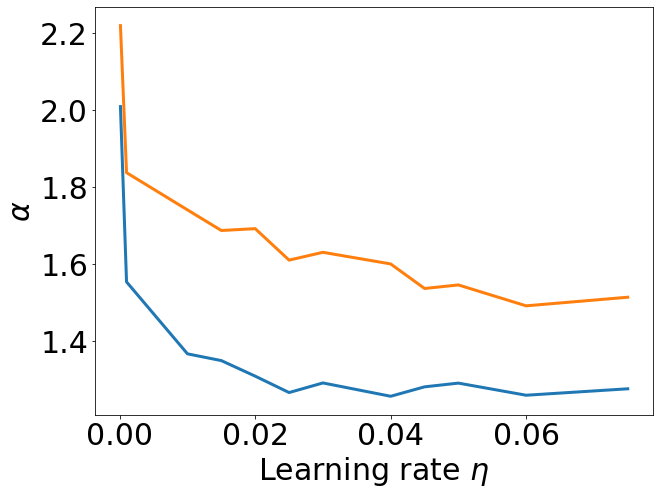

In [33]:
nodes = 8
j = 0
lr_list = [0.0001,
0.001,
0.01,
0.015,
0.02,
0.025,
0.03,
0.04,
0.045,
0.05,
0.06,
0.075]
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,7.5))
for alpha in alphas_mc_nodes:
    plt.plot(lr_list ,alpha[:,j],linewidth=3)
# plt.plot(lr_list, alpha_dis_all, linewidth = 3)
# plt.plot(lr_list, alpha_cent_all, linewidth = 3)
plt.plot(lr_list, alphas_mc_cent[:,j], linewidth = 3)
plt.xlabel(r'Learning rate $\eta$',fontsize=30)
plt.ylabel(r'$\alpha$',fontsize=30)
plt.tick_params(labelsize=30)
legendList = []
nodes_list = np.linspace(1,nodes,num = nodes)
for i in range(nodes):
    legendList.append('Node %1i' %nodes_list[i])
# legendList.append('Disconnect')
legendList.append('Centralized')
# bbox_to_anchor=(1,0.5)
# plt.legend(legendList,bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0,fontsize=30,ncol=5)
plt.show()